In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from helper_functions import accuracy_fn

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=2000,
                            n_features =NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 2,
                            random_state = RANDOM_SEED)

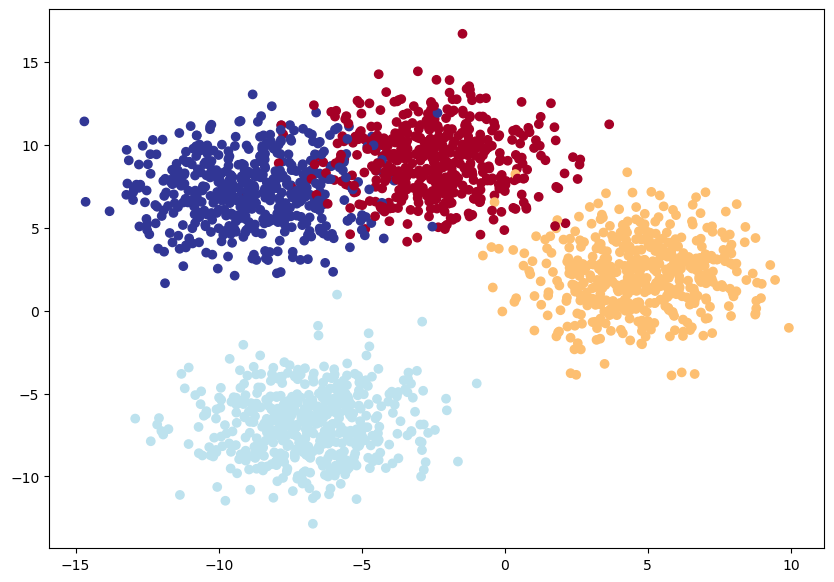

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob, cmap = plt.cm.RdYlBu)

In [5]:
# Device Agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
# Turn into torch tensors onto device
X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.long).to(device)

In [6]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

In [17]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 32):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.layers(x)

In [18]:
model_0 = BlobModel(input_features=2, output_features=4).to(device)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)

# Logits output -> pred probs -> pred labels
y_logits = model_0(X_blob_test)
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_labels = torch.argmax(y_pred_probs, dim = 1)


In [19]:
print(y_logits[:10])
print(y_pred_probs[:10])
print(y_pred_labels[:10])
print(y_blob_test[:10])

tensor([[ 0.2491,  0.9904,  0.8015, -0.7570],
        [-0.1964,  0.0561, -0.0054,  0.0935],
        [ 0.9617,  1.6904, -0.1890, -0.3858],
        [-0.2207,  0.2991,  0.0794,  0.0803],
        [ 0.6711,  1.3164, -0.2075, -0.2419],
        [ 0.8229,  1.4674, -0.1440, -0.3567],
        [-0.1670,  0.0521, -0.0755, -0.1438],
        [-0.0931,  0.0375,  0.0117, -0.0765],
        [ 0.8922,  1.5780, -0.1745, -0.3652],
        [ 0.3156,  0.9549,  0.4084, -0.4756]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1922, 0.4035, 0.3340, 0.0703],
        [0.2069, 0.2663, 0.2504, 0.2764],
        [0.2741, 0.5680, 0.0867, 0.0712],
        [0.1858, 0.3124, 0.2508, 0.2510],
        [0.2686, 0.5121, 0.1116, 0.1078],
        [0.2783, 0.5303, 0.1058, 0.0856],
        [0.2291, 0.2853, 0.2511, 0.2345],
        [0.2344, 0.2671, 0.2603, 0.2383],
        [0.2767, 0.5494, 0.0952, 0.0787],
        [0.2249, 0.4263, 0.2468, 0.1020]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([1, 3, 1, 1

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 200

train_loss_values = torch.empty(epochs, requires_grad=False).to(device)
test_loss_values = torch.empty(epochs, requires_grad=False).to(device)
train_acc_values = torch.empty(epochs, requires_grad=False).to(device)
test_acc_values = torch.empty(epochs, requires_grad=False).to(device)
epoch_count = torch.empty(epochs, requires_grad=False).to(device)

for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_blob_train)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                          y_pred=y_pred )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_blob_test)
        test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

        test_loss = loss_fn(test_logits, y_blob_test)

        test_acc = accuracy_fn(y_true=y_blob_test,
                          y_pred=test_pred )

        epoch_count[[epoch]] = epoch
        test_loss_values[[epoch]] = test_loss
        test_acc_values[[epoch]] = test_acc
        train_loss_values[[epoch]] = loss
        train_acc_values[[epoch]] = acc
    if epoch %10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.73864 | Acc: 2.50% | Test Loss: 1.61881 | Test Acc: 7.75%
Epoch: 10 | Loss: 1.07012 | Acc: 76.69% | Test Loss: 1.03766 | Test Acc: 80.25%
Epoch: 20 | Loss: 0.78887 | Acc: 90.75% | Test Loss: 0.76963 | Test Acc: 89.75%
Epoch: 30 | Loss: 0.61311 | Acc: 93.50% | Test Loss: 0.59951 | Test Acc: 93.25%
Epoch: 40 | Loss: 0.49282 | Acc: 94.50% | Test Loss: 0.48238 | Test Acc: 93.25%
Epoch: 50 | Loss: 0.40651 | Acc: 95.12% | Test Loss: 0.39819 | Test Acc: 93.75%
Epoch: 60 | Loss: 0.34314 | Acc: 95.31% | Test Loss: 0.33658 | Test Acc: 94.25%
Epoch: 70 | Loss: 0.29634 | Acc: 95.69% | Test Loss: 0.29122 | Test Acc: 94.25%
Epoch: 80 | Loss: 0.26146 | Acc: 95.81% | Test Loss: 0.25738 | Test Acc: 94.25%
Epoch: 90 | Loss: 0.23498 | Acc: 95.88% | Test Loss: 0.23162 | Test Acc: 94.75%
Epoch: 100 | Loss: 0.21447 | Acc: 95.94% | Test Loss: 0.21158 | Test Acc: 95.25%
Epoch: 110 | Loss: 0.19830 | Acc: 95.88% | Test Loss: 0.19570 | Test Acc: 95.25%
Epoch: 120 | Loss: 0.18532 | Acc: 95.94% 

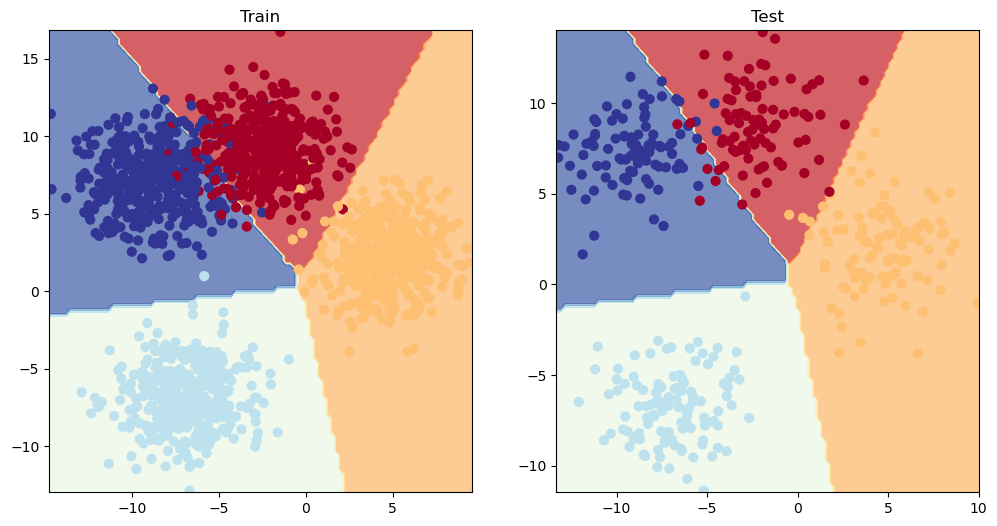

In [25]:
# Plot decision boundary
from helper_functions import plot_predictions, plot_decision_boundary

model_0.eval()
with torch.inference_mode():
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    plot_decision_boundary(model_0, X_blob_train, y_blob_train)
    plt.subplot(1,2,2)
    plt.title('Test')
    plot_decision_boundary(model_0, X_blob_test, y_blob_test)

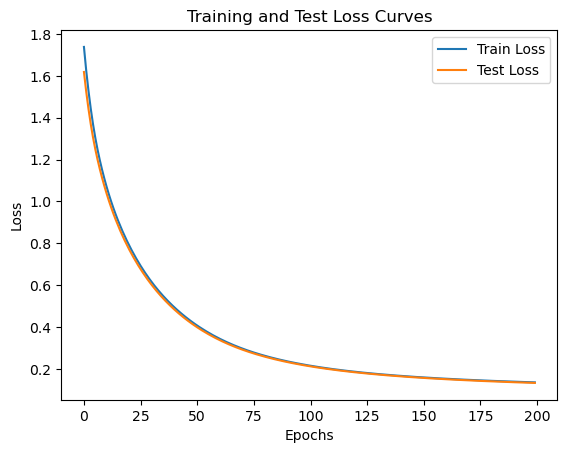

In [22]:
model_0.eval()
with torch.inference_mode():
    plt.plot(epoch_count.cpu(), train_loss_values.cpu(), label = 'Train Loss')
    plt.plot(epoch_count.cpu(), test_loss_values.cpu(), label = 'Test Loss')
    plt.title("Training and Test Loss Curves")
    plt.ylabel ('Loss')
    plt.xlabel('Epochs')
    plt.legend()

<img src ="https://ml-cheatsheet.readthedocs.io/en/latest/_images/cross_entropy.png" width = "800">

In [23]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassConfusionMatrix, MulticlassF1Score

torchmetric_accuracy = MulticlassAccuracy(task = 'multiclass' , num_classes=4).to(device)
torchmetric_precision = MulticlassPrecision(task='multiclass', num_classes=4).to(device)
torchmetric_recall = MulticlassRecall(task='multiclass', num_classes=4).to(device)
torchmetric_f1score = MulticlassF1Score(task='multiclass', num_classes=4).to(device)
torchmetric_cf = MulticlassConfusionMatrix(task='multiclass', num_classes=4).to(device)

print(f"Accuracy:{torchmetric_accuracy(test_pred, y_blob_test):.3f}")
print(f"Precision:{torchmetric_precision(test_pred, y_blob_test):.5f}")
print(f"Recall:{torchmetric_recall(test_pred, y_blob_test):.5f}")
print(f"F1Score:{torchmetric_f1score(test_pred, y_blob_test):.5f}")

Accuracy:0.952
Precision:0.95166
Recall:0.95155
F1Score:0.95156


In [24]:
torchmetric_cf(test_pred, y_blob_test)

tensor([[ 78,   1,   0,   8],
        [  3, 100,   0,   0],
        [  0,   0, 112,   0],
        [  6,   0,   0,  92]], device='cuda:0')